In [1]:
import os
from math import log10

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from skimage.transform import resize

In [286]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision.models.vgg import vgg16

from sr_kspace import transforms as T
from sr_kspace.model import Generator
from sr_kspace.utils import SRKspaceData, gray2rgb, calculate_ssim, calculate_psnr, calculate_mae, save_images

In [274]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

In [276]:
PATH_TO_SOURCE_TRAIN = 'data/ax_t2_source_train'
PATH_TO_SOURCE_VAL = 'data/ax_t2_source_val'
PATH_TO_SOURCE_TEST = 'data/ax_t2_source_test'

PATH_TO_X4_MODEL = 'models/netG_epoch_4_100.pth'
PATH_TO_X8_MODEL = 'models/netG_epoch_8_100.pth'

UPSCALE_FACTOR = 2
RANDOM_STATE = 42

In [289]:
class SRGANMRIDataLoader(Dataset):
    def __init__(self, path_to_data, scale_factor, seed=None):
        super().__init__()

        self.data = [os.path.join(path_to_data, file) for file in os.listdir(path_to_data) 
                       if file.endswith('.npy')]
        self.scale_factor = scale_factor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        slice = np.load(self.data[idx])
        h, w = slice.shape[-2:]
        lr_slice = resize(slice[0], (h//self.scale_factor, w//self.scale_factor), preserve_range=True)
        slice = torch.from_numpy(slice).type(torch.float32)
        lr_slice = torch.from_numpy(lr_slice).unsqueeze(0).type(torch.float32)

        return slice, lr_slice
    
    
class VGGLoss(nn.Module):
    def __init__(self, as_gray=False):
        super().__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.as_gray = as_gray
        self.mse_loss = nn.MSELoss()

    def forward(self, img1, img2):
        if self.as_gray:
            img1 = torch.cat([img1, img1, img1], dim=-3)
            img2 = torch.cat([img2, img2, img2], dim=-3)
            
        perception_loss = self.mse_loss(self.loss_network(img1), self.loss_network(img2))
        return perception_loss

In [292]:
def init_data_loaders(batch_size=4, random_subset=None, val_size=None):
    train_set = SRGANMRIDataLoader(PATH_TO_SOURCE_TRAIN, UPSCALE_FACTOR)
    val_set = SRGANMRIDataLoader(PATH_TO_SOURCE_VAL, UPSCALE_FACTOR)
    if val_size:
        val_set.data = val_set.data[:val_size]

    if random_subset:
        sampler = RandomSampler(train_set, replacement=True, num_samples=random_subset)
        train_loader = DataLoader(train_set, sampler=sampler, batch_size=batch_size,
                                             shuffle=False, num_workers=4)
    else:
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)

    val_loader = DataLoader(val_set, batch_size=1, shuffle=False, num_workers=4)

    return train_loader, val_loader

In [295]:
train_loader, val_loader = init_data_loaders(random_subset=5, val_size=5)
len(train_loader), len(val_loader.dataset), 

(2, 5)

torch.FloatTensor torch.FloatTensor
torch.Size([1, 320, 320]) torch.Size([1, 160, 160])


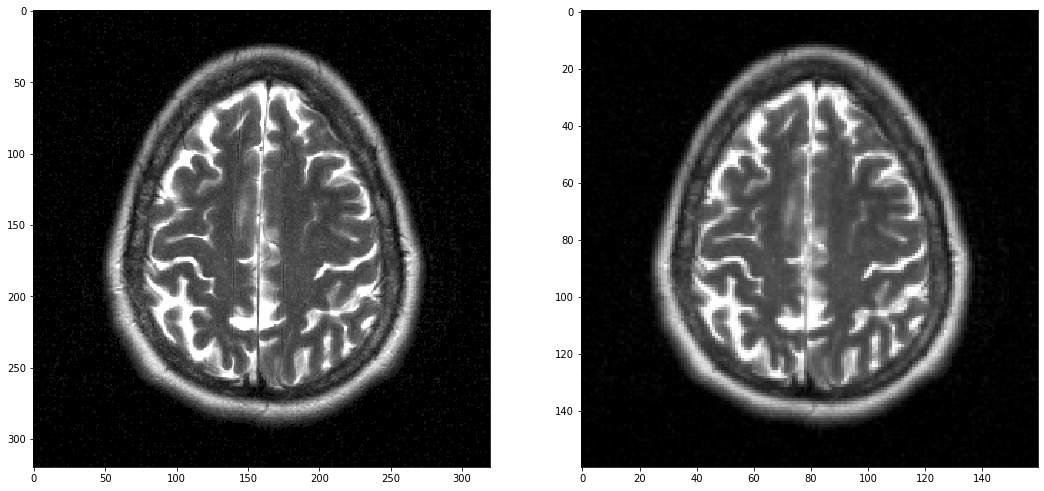

In [296]:
hr, lr = train_set.__getitem__(228)

print(hr.type(), lr.type())
print(hr.shape, lr.shape)

fig, axis = plt.subplots(1, 2, figsize=(18, 9))
axis[0].imshow(hr[0], cmap='gray')
axis[1].imshow(lr[0], cmap='gray')

In [297]:
def copy_res_layers(netG):
    pretrained_G = Generator(4)
    x4_params = torch.load(PATH_TO_X4_MODEL, map_location=torch.device('cpu'))
    pretrained_G.load_state_dict(x4_params)

    netG.block2.load_state_dict(pretrained_G.block2.state_dict())
    netG.block3.load_state_dict(pretrained_G.block3.state_dict())
    netG.block4.load_state_dict(pretrained_G.block4.state_dict())
    netG.block5.load_state_dict(pretrained_G.block5.state_dict())
    netG.block6.load_state_dict(pretrained_G.block6.state_dict())

    static_layers = [f'block{i}' for i in range(2, 7)]
    for k, w in netG.named_parameters():
        if any(k.startswith(l) for l in static_layers):
            w.requires_grad = False

In [298]:
netG = Generator(UPSCALE_FACTOR, input_channels=1, output_channels=1)
copy_res_layers(netG)

In [299]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

netG = Generator(UPSCALE_FACTOR, input_channels=1, output_channels=1)
copy_res_layers(netG)
print('Number of params:', sum(p.numel() for p in netG.parameters() if p.requires_grad))

criterion = nn.MSELoss()
vgg_criterion = VGGLoss(as_gray=True)

if torch.cuda.is_available():
    netG.cuda()
    generator_criterion.cuda()

optimizer = optim.Adam(netG.parameters(), lr=1e-3)

Device: cpu
Number of params: 195076


In [ ]:
results = {'vgg_loss': [], 'psnr': [], 'ssim': [], 'mae': [], 'mse': []}
epochs = 15

label = f'srgan_{UPSCALE_FACTOR}'
print('Model:', label)

out_path = f'results/{label}/'
os.makedirs(os.path.join(out_path, 'images'), exist_ok=True)
os.makedirs(os.path.join(out_path, 'models'), exist_ok=True)


for epoch in range(1, epochs + 1):
    train_bar = tqdm(train_loader)
    running_results = {'batch_sizes': 0, 'mse': 0, 'vgg_loss': 0}

    netG.train()
    for hr, lr in train_bar:
        batch_size = hr.size(0)
        running_results['batch_sizes'] += batch_size

        if torch.cuda.is_available():
            hr = hr.cuda()
            lr = lr.cuda()

        sr = netG(lr)
        loss = criterion(hr, sr)
        vgg_loss = vgg_criterion(hr, sr)

        optimizer.zero_grad()
        vgg_loss.backward(retain_graph=True)
        loss.backward()
        optimizer.step()

        running_results['vgg_loss'] += vgg_loss.item() * batch_size
        running_results['mse'] += loss.item() * batch_size

        train_bar.set_description(desc='[%d/%d] MSE: %.4f VGG_loss: %.4f' % (
            epoch, epochs, running_results['mse'] / running_results['batch_sizes'],
            running_results['vgg_loss'] / running_results['batch_sizes']))

        break


    netG.eval()
    val_bar = tqdm(val_loader)
    valing_results = {'mae': 0, 'ssims': 0, 'psnr': 0, 'ssim': 0, 'batch_sizes': 0}

    for hr, lr in val_bar:
        batch_size = hr.size(0)
        valing_results['batch_sizes'] += batch_size
        if torch.cuda.is_available():
            hr = hr.cuda()
            lr = lr.cuda()

        sr = netG(lr)

        valing_results['mae'] += calculate_mae(hr, sr) * batch_size
        valing_results['ssim'] += calculate_ssim(hr, sr) * batch_size
        valing_results['psnr'] += calculate_psnr(hr, sr) * batch_size
        val_bar.set_description(
            desc='[converting LR images to SR images] PSNR: %.4f dB SSIM: %.4f' % (
                valing_results['psnr'], valing_results['ssim']))

        break

    save_images(hr, sr, abs(sr - hr), 
                path=os.path.join(out_path, 'images', f'val_{label}_{epoch}.png'))
    

    torch.save(netG.state_dict(), 
               os.path.join(out_path, 'models', f'netG_epoch_{label}_{epoch}.pth'))

    results['mse'].append(running_results['mse'] / running_results['batch_sizes'])
    results['vgg_loss'].append(running_results['vgg_loss'] / running_results['batch_sizes'])
    results['psnr'].append(valing_results['psnr'])
    results['ssim'].append(valing_results['ssim'])
    results['mae'].append(valing_results['mae'])

    if epoch % 1 == 0:
        data_frame = pd.DataFrame(
            data={'MSE': results['mse'], 'vgg_loss': results['vgg_loss'],
                  'PSNR': results['psnr'], 'SSIM': results['ssim'], 'MAE': results['mae']},
            index=range(1, epoch + 1))

        data_frame.to_csv(os.path.join(out_path, f'metrics_val_{label}.csv'), 
                          index_label='Epoch')

Model: srgan_2
